In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

np.set_printoptions(precision=3, suppress=True)

In [57]:
df = pd.read_csv('oregon-house-prices.csv')
print('The first 10 rows:\n\n', df.head(10))

The first 10 rows:

    House Size (ft²)  Bedrooms   Price
0              2104         3  399900
1              1600         3  329900
2              2400         3  369000
3              1416         2  232000
4              3000         4  539900
5              1985         4  299900
6              1534         3  314900
7              1427         3  198999
8              1380         3  212000
9              1494         3  242500


Non-alphanumeric chars in column names are _"sabad"_/annoying, they're difficult to type, and may
even lead to errors like
```
    House Size (ft² )>=1600 and House Size (ft² )<=1700
                  ^
    SyntaxError: Python keyword not valid identifier in numexpr query
```
so let's rename

In [58]:
df = df.rename(columns={'House Size (ft²)': 'House Size'})
df.head()

,House Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


For the purpose of normalization, let's get the lowest and highest house size, and also bedrooms. 

In [59]:
df.min()

House Size       852
Bedrooms           1
Price         169900
dtype: int64

In [60]:
df.max()

House Size      4478
Bedrooms           5
Price         699900
dtype: int64

While Tensorflow works with _some_ Pandas DataFrames, some libraries like [Scikit-learn](https://scikit-learn.org/), which we'll use for feature scaling here, don't work well with Pandas DataFrames.  Thus, you'll see the `to_numpy()` conversion when extracting
$X$ and $y$.

> Unfortunately, scikit-learn works directly with numpy arrays or scipy sparse arrays, but not `pandas.DataFrame` which is widespread in data science work.

And when not converting, we see this little warning.

```
UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
```

In [61]:
X = df[['House Size', 'Bedrooms']].to_numpy()
y = df[['Price']].to_numpy() / 100_000
print('The first 10 rows as a Numpy array:\n', X[0:10])

The first 10 rows as a Numpy array:
 [[2104    3]
 [1600    3]
 [2400    3]
 [1416    2]
 [3000    4]
 [1985    4]
 [1534    3]
 [1427    3]
 [1380    3]
 [1494    3]]


In [62]:
print('The first 10 prices as a Numpy array:\n', y[0:10])

The first 10 prices as a Numpy array:
 [[3.999]
 [3.299]
 [3.69 ]
 [2.32 ]
 [5.399]
 [2.999]
 [3.149]
 [1.99 ]
 [2.12 ]
 [2.425]]


### Wait a minute, why divide price by 10,000?

Because our loss function is Mean Square Error,

it will get the **sum** of the **SQUARES** of very large numbers first, before getting the average
by dividing it with the number of training samples $m$, as seen in the formula:

#### Vectorized
$\frac{1}{2m}(\hat{y} - y)^T(\hat{y} - y)$

### Unvectorized

$\frac{1}{2m} \sum\limits_{i = 1}^{m}(y_i - \hat{y_i})^2$


```
Epoch 1/200
2/2 [==============================] - 0s 2ms/step - loss: 3346001899810717696.0000
Epoch 2/200
2/2 [==============================] - 0s 3ms/step - loss: 17488194481918713621838967942938624.0000
Epoch 3/200
2/2 [==============================] - 0s 2ms/step - loss: inf
Epoch 4/200
2/2 [==============================] - 0s 3ms/step - loss: inf
Epoch 5/200
2/2 [==============================] - 0s 2ms/step - loss: inf
```

As discussed in the slides, we do feature scaling first.

In [63]:
scaler = MinMaxScaler().fit(X)
X_norm = scaler.transform(X)
print('Original X:\n', X[0:10], '\n\n', 'Normalized X:\n', X_norm[0:10])

Original X:
 [[2104    3]
 [1600    3]
 [2400    3]
 [1416    2]
 [3000    4]
 [1985    4]
 [1534    3]
 [1427    3]
 [1380    3]
 [1494    3]] 

 Normalized X:
 [[0.345 0.5  ]
 [0.206 0.5  ]
 [0.427 0.5  ]
 [0.156 0.25 ]
 [0.592 0.75 ]
 [0.312 0.75 ]
 [0.188 0.5  ]
 [0.159 0.5  ]
 [0.146 0.5  ]
 [0.177 0.5  ]]


## Target values for $w$

I cross-checked this in another _"less-overkill"_ library - Scikit-learn, using its
`sklearn.linear_model.LinearRegression` model, and I got the following results:

$$
w = \begin{bmatrix}
  w_0 \\
  w_1 \\
  w_2
\end{bmatrix} = 
\begin{bmatrix}
  1.995 \\
  5.048 \\
  -0.35
\end{bmatrix}
$$

If we want to predict the price of a $1,650$ sq.ft. house with $3$ bedrooms, then
we have to normalize these inputs as well. 
- $1,650$ becomes $0.22$, and
- $3$ being the median becomes $0.5$.

So that's 

$\hat{y} = w_2x_2 + w_1x_1 + w_0$  
$\hat{y} = -0.35 \cdot 0.5 + 5.048 \cdot 0.22 + 1.995$  
$\hat{y} = 2.93056$

but we have to scale it back to $\times 100k$ USD, our prediction is $293,056$ USD.

So the model you will code below in Tensorflow should be somewhere around that ballpark.

**⚠ Spoiler alert:** I got:
$$
w = \begin{bmatrix}
  w_0 \\
  w_1 \\
  w_2
\end{bmatrix} = 
\begin{bmatrix}
  1.96 \\
  4.975 \\
  -0.26
\end{bmatrix}
$$

- it predicts $291,623.855$ for the same house size ($1650$) and # of bedrooms ($3$).
- it used $\alpha = 0.05$, and trained for $1,000$ epochs.

Let's see if $291.6k$ USD is a good prediction for a $1,650 ft^2$ house with $3$ bedrooms.

In [73]:
df.query('`House Size` >= 1500 and `House Size` <= 1800').sort_values('House Size')

,House Size,Bedrooms,Price
6,1534,3,314900
1,1600,3,329900
22,1604,3,242900
40,1664,2,368500
20,1767,3,252900


In [65]:
model = keras.Sequential([
  keras.layers.Dense(units=1, input_shape=[2])
])

adam = keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=adam, loss='mean_squared_error')

In [66]:
history = model.fit(X_norm, y, epochs=1000)

Epoch 1/1000
2/2 [==============================] - 0s 2ms/step - loss: 15.1157
Epoch 2/1000
2/2 [==============================] - 0s 3ms/step - loss: 13.7358
Epoch 3/1000
2/2 [==============================] - 0s 2ms/step - loss: 12.3664
Epoch 4/1000
2/2 [==============================] - 0s 2ms/step - loss: 11.1495
Epoch 5/1000
2/2 [==============================] - 0s 3ms/step - loss: 9.9385
Epoch 6/1000
2/2 [==============================] - 0s 2ms/step - loss: 8.8768
Epoch 7/1000
2/2 [==============================] - 0s 2ms/step - loss: 7.8661
Epoch 8/1000
2/2 [==============================] - 0s 3ms/step - loss: 6.9143
Epoch 9/1000
2/2 [==============================] - 0s 2ms/step - loss: 6.1065
Epoch 10/1000
2/2 [==============================] - 0s 2ms/step - loss: 5.3100
Epoch 11/1000
2/2 [==============================] - 0s 3ms/step - loss: 4.5920
Epoch 12/1000
2/2 [==============================] - 0s 2ms/step - loss: 3.9895
Epoch 13/1000
2/2 [==========================

In [67]:
from sklearn.linear_model import LinearRegression

sklearn_model = LinearRegression().fit(X_norm, y)
sklearn_model.coef_, sklearn_model.intercept_, sklearn_model.predict(scaler.transform(np.array([
  [1650, 3]
]))) * 100_000

(array([[ 5.048, -0.35 ]]), array([1.995]), array([[293081.464]]))

In [68]:
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[ 5.083],
        [-0.342]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([1.959], dtype=float32)>]

In [69]:
model.predict(scaler.transform(np.array([
  [1650, 3]
]))) * 100_000, scaler.transform(np.array([
  [1650, 3]
]))

(array([[290639.615]]), array([[0.22, 0.5 ]]))

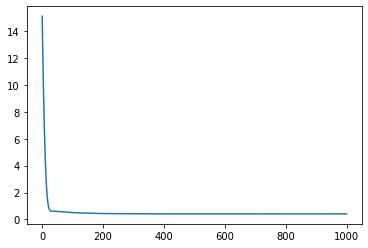

In [70]:
plt.plot(history.epoch, history.history['loss'])